<a href="https://colab.research.google.com/github/GitBar20/AI/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_varfarin_parsed_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Парсинг данных - выделение по группам
* возрастов
* диагнозов
* вычисление относительной даты анализа

A.A. Bar

In [ ]:
# В файл ЦАТ_общий_parsed_extDS_v6.xlsx относительно ЦАТ_общий_parsed.xlsx
# добавлены:
# institution_id - id лечебного учреждения (на основании первого столбца с названием)
# diagnos и sss - записи о диагнозе и сердечно-сосудистых событиях из первичных файлов

# Группы диагнозов: обрабатываются поля диагнозов и сердечно-сосудистых событий
# d1 - Протезирование клапанов
# d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
# d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
# d4 - (I05-09)Ревматическая болезнь сердца
# d5 - (I35)Неревматические поражения аортального клапана
# d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
# d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
# d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)

# Группы возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

# Относительная давность анализа:
# date_from_1990 = количество дней от 01.01.1990 до date_analyse



In [2]:
import os
import gdown
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from datetime import datetime

#import phik
#from phik import resources, report
!apt-get -qq install -y graphviz && pip install phik
import phik




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 6.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive   # Подключаем google диск
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# файл по ссылке
# ЦАТ_общий_parsed_extDS_v6.xlsx
# - к структуре файла ЦАТ_общий_parsed подтянуты диагнозы и сердечно-сосудистые события
#https://docs.google.com/spreadsheets/d/1jM3sKBzEMl0u1FqUHavgUVOSq4VEfj53/edit?usp=drive_link&ouid=114216268352719874606&rtpof=true&sd=true
idd = "1jM3sKBzEMl0u1FqUHavgUVOSq4VEfj53"
gdown.download(f"https://drive.google.com/uc?id={idd}", "ЦАТ_общий_parsed_plus.xlsx", quiet=False) # переписать файл в каталог

catalogs_path = '/content/'
file_name =  'ЦАТ_общий_parsed_plus.xlsx'
df = pd.read_excel(catalogs_path + file_name, decimal=",")
#df.head()
data = df.copy()

Downloading...
From: https://drive.google.com/uc?id=1jM3sKBzEMl0u1FqUHavgUVOSq4VEfj53
To: /content/ЦАТ_общий_parsed_plus.xlsx
100%|██████████| 199k/199k [00:00<00:00, 45.9MB/s]


## Функции для формирования доп.колонок

In [6]:
# Сформируем колонки по группам возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

def get_level(x):
# age_level	0-10-30-50-60-70-80-90+
    if x < 10 : return 0
    if x >= 10 and x < 30 : return 10
    if x >= 30 and x < 50 : return 30
    if x >= 50 and x < 60 : return 50
    if x >= 60 and x < 70 : return 60
    if x >= 70 and x < 80 : return 70
    if x >= 80 and x < 90 : return 80
    return 90

def get_level1(x):
# age_level1	0-50-65-75-80+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 80 : return 75
    return 80

def get_level2(x):
# age_level2	0-35-50-65-80+
    if x < 35 : return 0
    if x >= 35 and x < 50 : return 35
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level3(x):
# age_level3	0-50-65-75-90+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 90 : return 75
    return 90

def get_level4(x):
# age_level4	0-50-65-80
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level5(x):
# age_level5	0-50-65+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    return 65

In [7]:
# поисковые конструкции для diagnos и sss
# for d1 -диагноз или ссс содержат слово "проте"
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
# for d5-  I35,i35
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
# for d7 - аорт, митр,клап,перегор
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац

def get_d1(x):
  # for d1 -диагноз или ссс содержат слово "проте"
  wlist = ['проте']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d2(x):
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
  wlist = ['фибр', 'фебр','ФП','трепет','i48','I48','I 48']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d3(x):
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
  wlist = ['порок','ИБС','склероз','ОИМ','инфаркт','миокард','стенокар','I20',
           'I25','ПИКС','пикс','ишемич','кард','ВПС','ОКС','стенокард',
           'ТИА','эндокардит','порок']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d4(x):
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
  wlist = ['I 08','I05','i05','i08','I06','I09','ревмат']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d5(x):
# for d5-  I35,i35
  wlist = ['I35','i35']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d6(x):
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
  wlist = ['ДКМП', 'I42', 'ОНМК','i34','Q231','ГБ','легочн','ТЭЛА']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d7(x):
# for d7 - аорт, митр,клап,перегор
  wlist = ['аорт', 'митр','клап','перегор']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d8(x):
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац
  wlist = ['АКШ','МКШ','шунт','стент','ЭКС','РЧА','аблац']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

## Формирование доп.колонок -2

In [8]:
# dose/prev_INR(MHO):  Вычислим  отношение начального дозы к МНО  :
data.insert(4, "dose/prev_INR(MHO)", data["dose"] / data["prev_INR(MHO)"]), True
#------------------------------------

# # INR(MHO)/prev_INR(MHO):  Вычислим  отношение INR(MHO) к prev_INR(MHO)  :
data.insert(5, "INR(MHO)/prev_INR(MHO)", data["INR(MHO)"] / data["prev_INR(MHO)"]), True
#------------------------------------

#(analise-birth)_date: Вычислим  количество дней от года рождения до даты анализа:
data.insert(5, "(analise-birth)_date", pd.to_timedelta(data['age'] * 365, unit='d')), True
#------------------------------------
data





,Unnamed: 0,institution,id,gender,dose/prev_INR(MHO),(analise-birth)_date,INR(MHO)/prev_INR(MHO),age,dose,date_analyse,...,age_level5,age_level6,d1,d2,d3,d4,d5,d6,d7,d8
0,0,123,140361892057136,0,2.411576,20805 days,1.067524,57,7.500,2022-11-11,...,50,0,0,1,0,0,0,0,0,0
1,1,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,0,2.259036,20805 days,0.605422,57,7.500,2022-11-24,...,50,0,0,1,0,0,0,0,0,0
2,2,ГБУЗ РБ Толбазинская ЦРБ,140361892057264,1,2.487562,18250 days,1.368159,50,5.000,2022-11-22,...,50,0,1,0,0,0,0,0,1,0
3,3,ГБУЗ РБ Толбазинская ЦРБ,140361892057392,0,4.401408,19345 days,1.802817,53,6.250,2022-11-21,...,50,0,0,1,0,0,0,0,0,0
4,4,ГБУЗ РБ Толбазинская ЦРБ,140361892057392,0,2.441406,19345 days,1.093750,53,6.250,2022-12-06,...,50,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,1463,ГБУЗ РБ Янаульская ЦРБ,139766010360000,1,2.798507,24820 days,1.716418,68,3.750,2022-08-02,...,65,65,0,1,0,0,0,0,0,0
1464,1464,ГБУЗ РБ Янаульская ЦРБ,139766010360144,1,2.500000,12775 days,0.693333,35,3.750,2022-03-31,...,0,0,0,1,0,0,0,0,0,0
1465,1465,ГБУЗ РБ Янаульская ЦРБ,139766010360144,1,3.605769,12775 days,0.990385,35,3.750,2022-09-23,...,0,0,0,1,0,0,0,0,0,0
1466,1466,ГБУЗ РБ Янаульская ЦРБ,139766010360288,0,0.892857,23360 days,1.139286,64,2.500,2022-11-07,...,50,0,0,0,0,0,1,0,1,0


In [10]:
data.to_excel(catalogs_path+'ЦАТ_общий_parsed_3 доп колонки.xlsx')

In [ ]:
# Сформируем колонки по группам возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

data['age_level'] = data['age'].apply(get_level)
data['age_level1'] = data['age'].apply(get_level1)
data['age_level2'] = data['age'].apply(get_level2)
data['age_level3'] = data['age'].apply(get_level3)
data['age_level4'] = data['age'].apply(get_level4)
data['age_level5'] = data['age'].apply(get_level5)
data['age_level6'] = np.where((data.age>=65), 65, 0)

In [ ]:
# Сформируем колонки по диагнозам и ССС: на основе колонок diagnos,sss
# d1 - Протезирование клапанов
# d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
# d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
# d4 - (I05-09)Ревматическая болезнь сердца
# d5 - (I35)Неревматические поражения аортального клапана
# d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
# d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
# d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)



In [11]:
# приводим к типу 'str'
data['diagnos'] = data['diagnos'].astype( str )
data['sss'] = data['sss'].astype( str )

In [12]:
data['d1'] = data.apply(lambda x: get_d1(x), axis=1)
data['d2'] = data.apply(lambda x: get_d2(x), axis=1)
data['d3'] = data.apply(lambda x: get_d3(x), axis=1)
data['d4'] = data.apply(lambda x: get_d4(x), axis=1)
data['d5'] = data.apply(lambda x: get_d5(x), axis=1)
data['d6'] = data.apply(lambda x: get_d6(x), axis=1)
data['d7'] = data.apply(lambda x: get_d7(x), axis=1)
data['d8'] = data.apply(lambda x: get_d8(x), axis=1)

In [ ]:
data

## Смотрим корреляцию, лишние колонки и т.д.

In [ ]:
# Удаляем столбцы
# data.drop(['institution', 'institution_id', 'id','date_analyse'], axis=1, inplace=True)
# data.drop(['diagnos', 'sss'], axis=1, inplace=True)
data.drop(['date_from_1990'], axis=1, inplace=True)

In [13]:
# сохраним результаты
data.to_excel(catalogs_path+'ЦАТ_общий_parsed_3 доп колонки_minus.xlsx')

<ipython-input-173-211baf13b4b7>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = np.triu(data.corr())
<ipython-input-173-211baf13b4b7>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), linewidths=.5, annot=True, cmap='YlGnBu', fmt='.1g')


<Axes: >

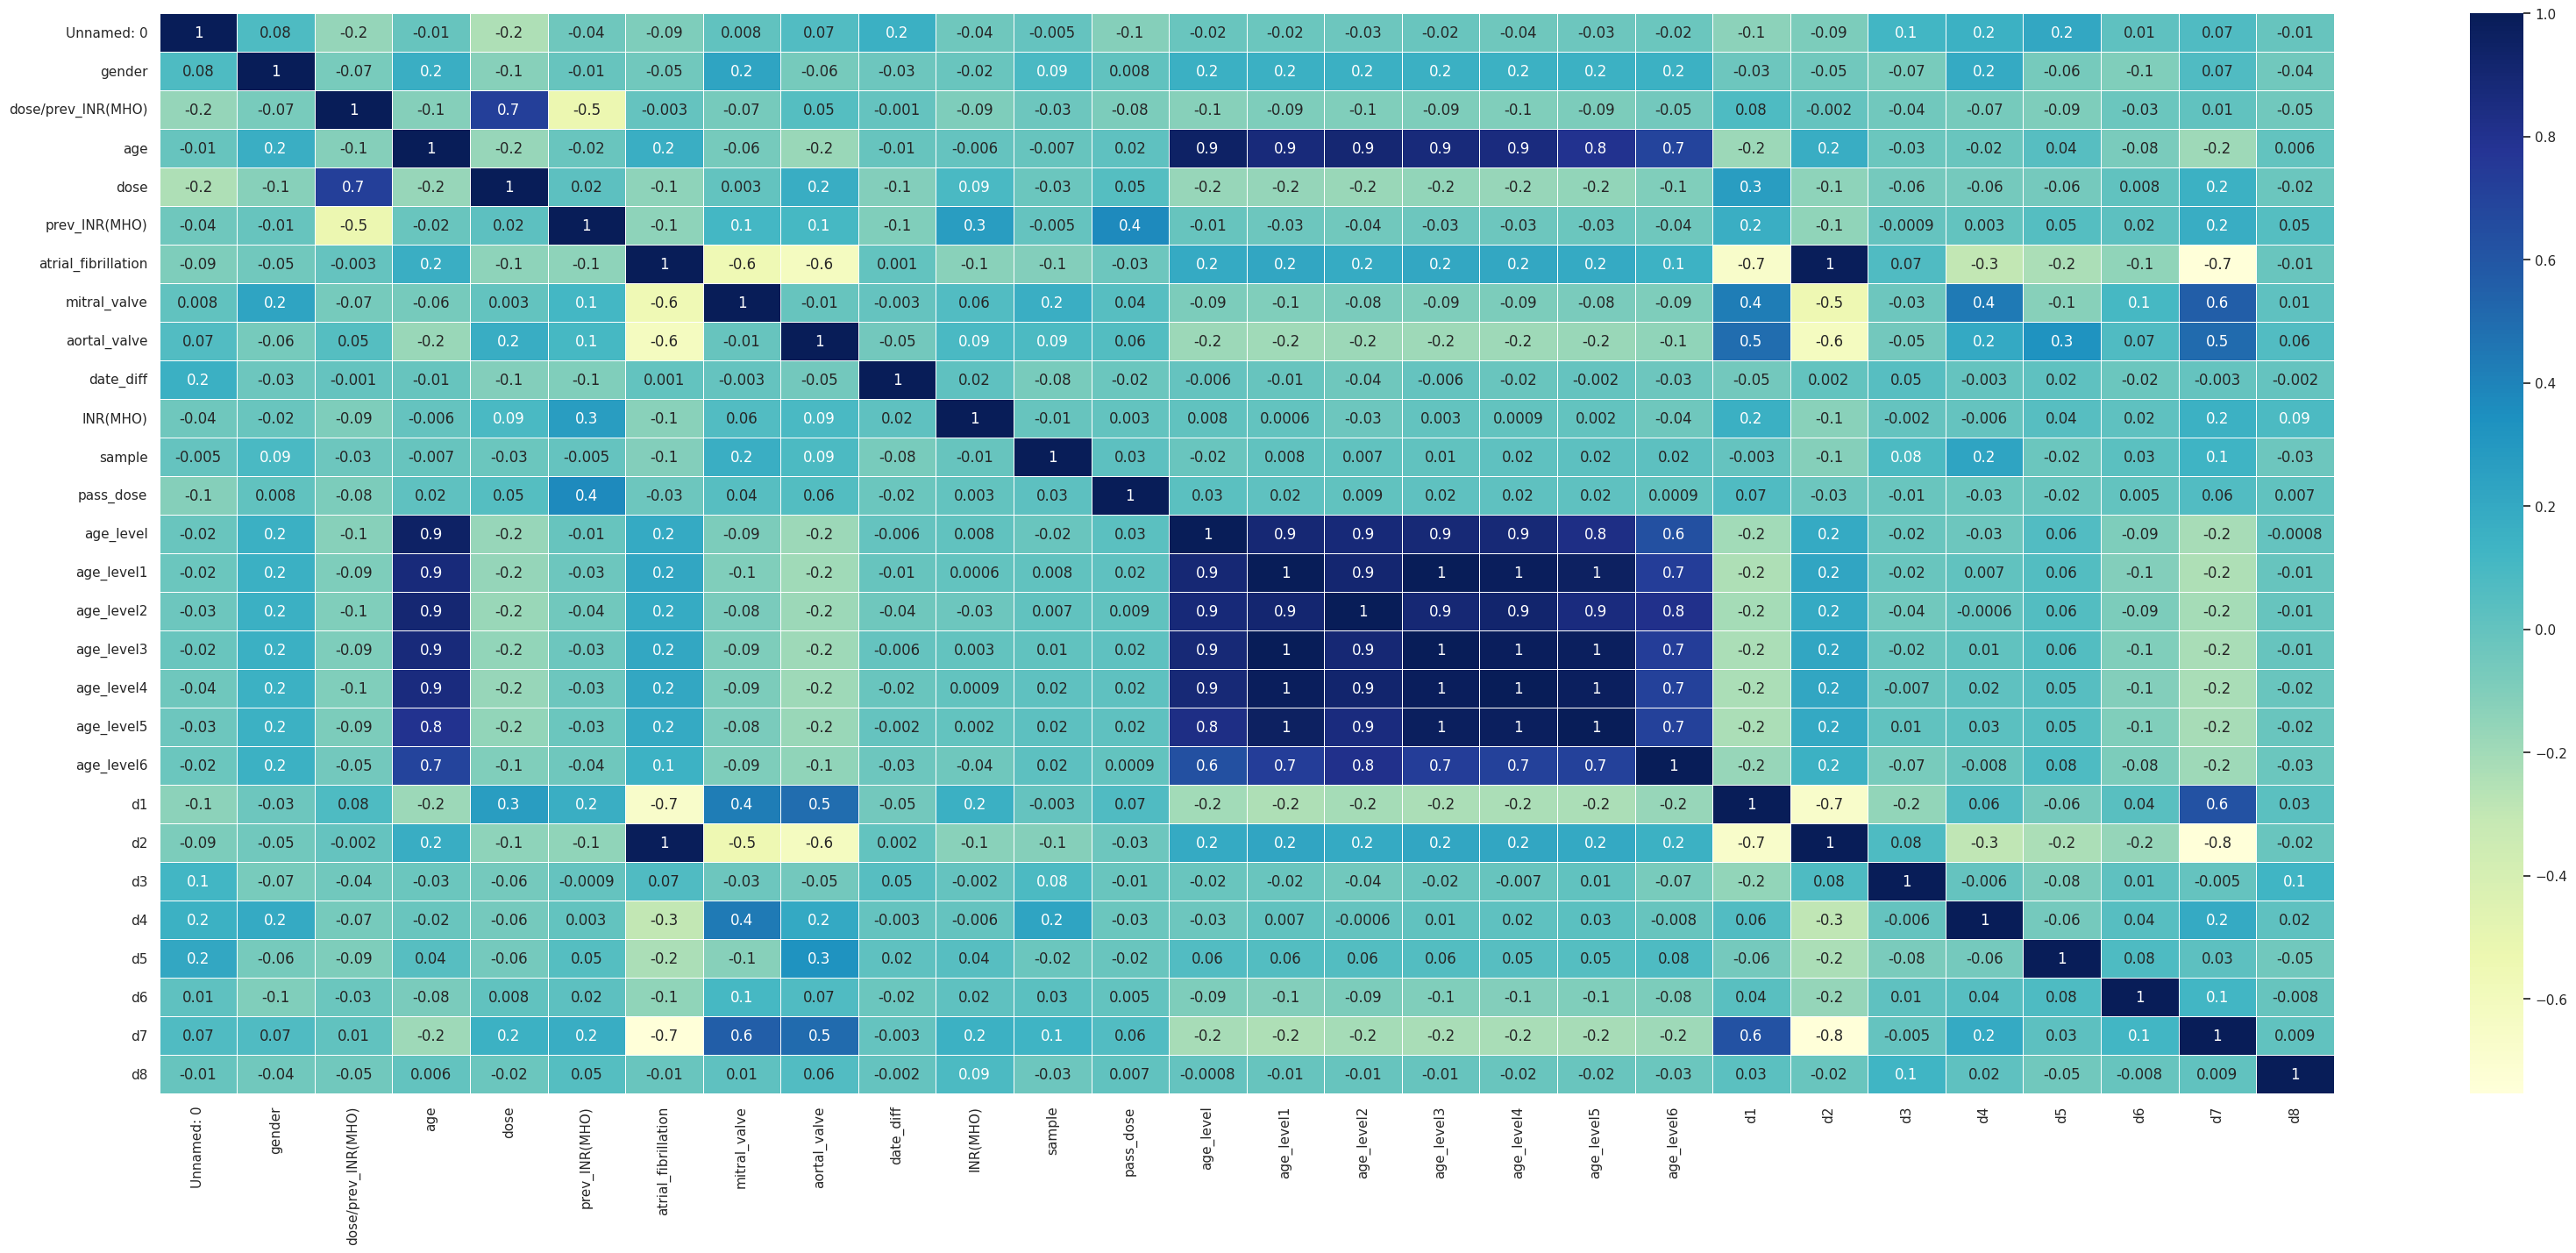

In [ ]:
# тепловая карта
sns.set(rc = {'figure.figsize':(40,16)})
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), linewidths=.5, annot=True, cmap='YlGnBu', fmt='.1g')

interval columns not set, guessing: ['Unnamed: 0', 'gender', 'age', 'dose', 'prev_INR(MHO)', 'atrial_fibrillation', 'mitral_valve', 'aortal_valve', 'date_diff', 'INR(MHO)', 'sample', 'pass_dose', 'date_from_1990', 'age_level', 'age_level1', 'age_level2', 'age_level3', 'age_level4', 'age_level5', 'age_level6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8']
interval columns not set, guessing: ['Unnamed: 0', 'gender', 'age', 'dose', 'prev_INR(MHO)', 'atrial_fibrillation', 'mitral_valve', 'aortal_valve', 'date_diff', 'INR(MHO)', 'sample', 'pass_dose', 'date_from_1990', 'age_level', 'age_level1', 'age_level2', 'age_level3', 'age_level4', 'age_level5', 'age_level6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8']


<Axes: >

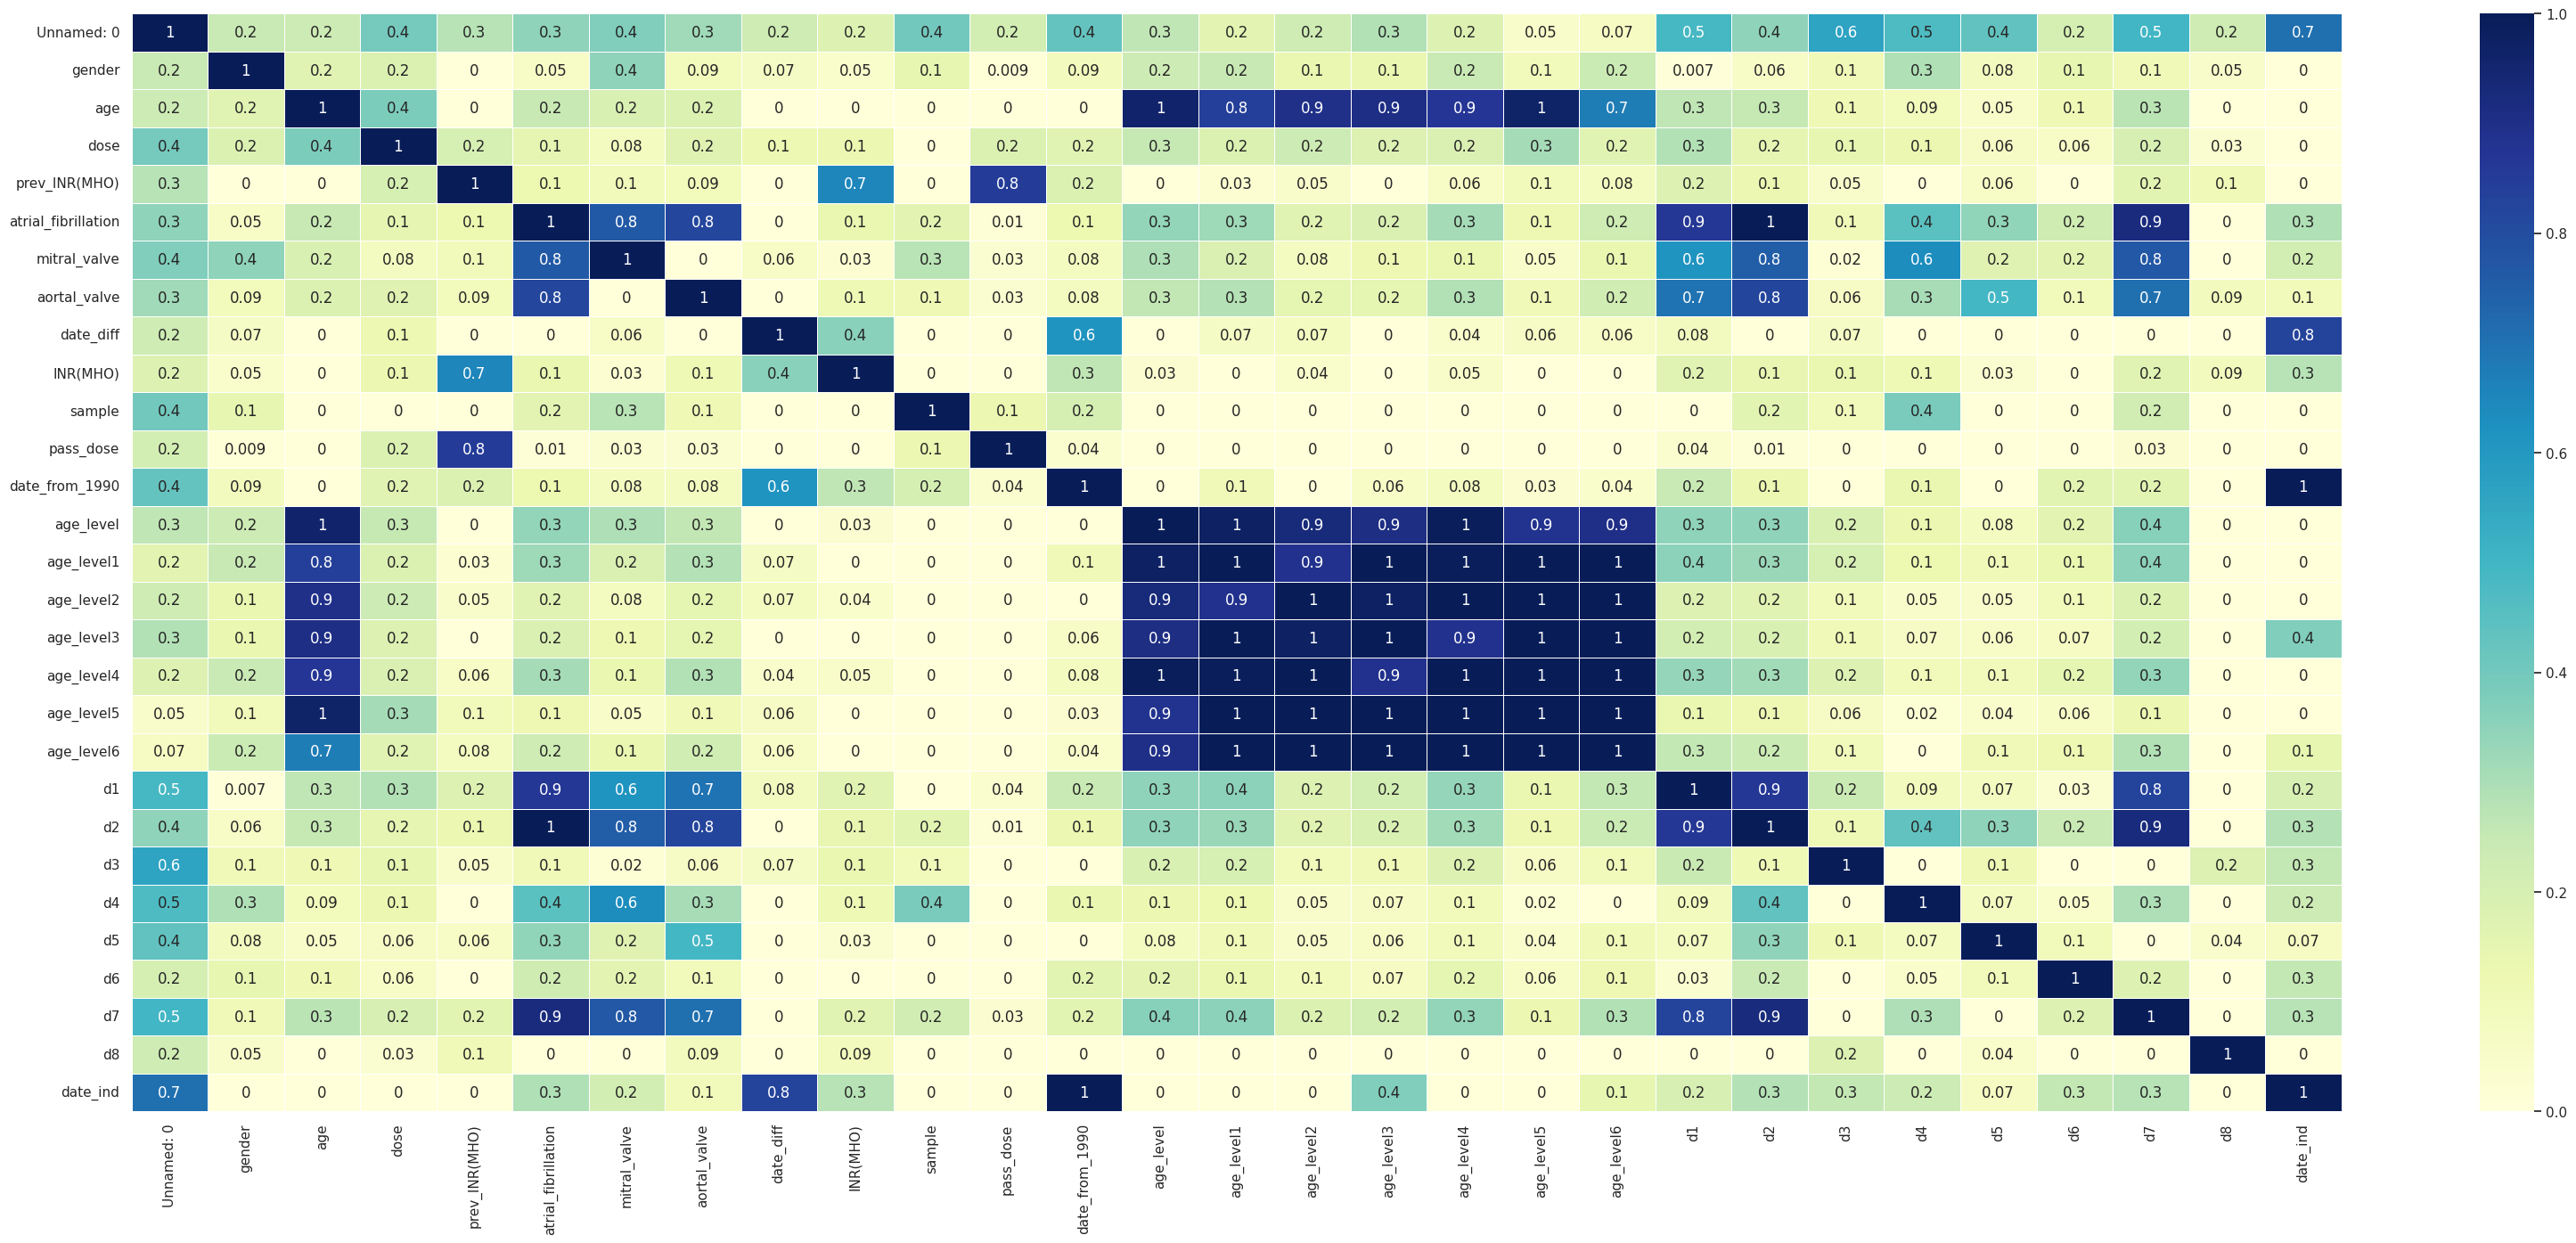

In [ ]:
# визуализация - тепловая карта phi_k
sns.set(rc = {'figure.figsize':(40,16)})
matrix = np.triu(data.phik_matrix())
sns.heatmap(data.phik_matrix(), linewidths=.5, annot=True, cmap='YlGnBu', fmt='.1g')

In [ ]:
# Удаляем столбцы
data.drop(['age_level1','age_level2', 'age_level3', 'age_level4'], axis=1, inplace=True)
data.drop(['d2','d3', 'd4','d5','d6','d8'], axis=1, inplace=True)

<ipython-input-176-211baf13b4b7>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = np.triu(data.corr())
<ipython-input-176-211baf13b4b7>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), linewidths=.5, annot=True, cmap='YlGnBu', fmt='.1g')


<Axes: >

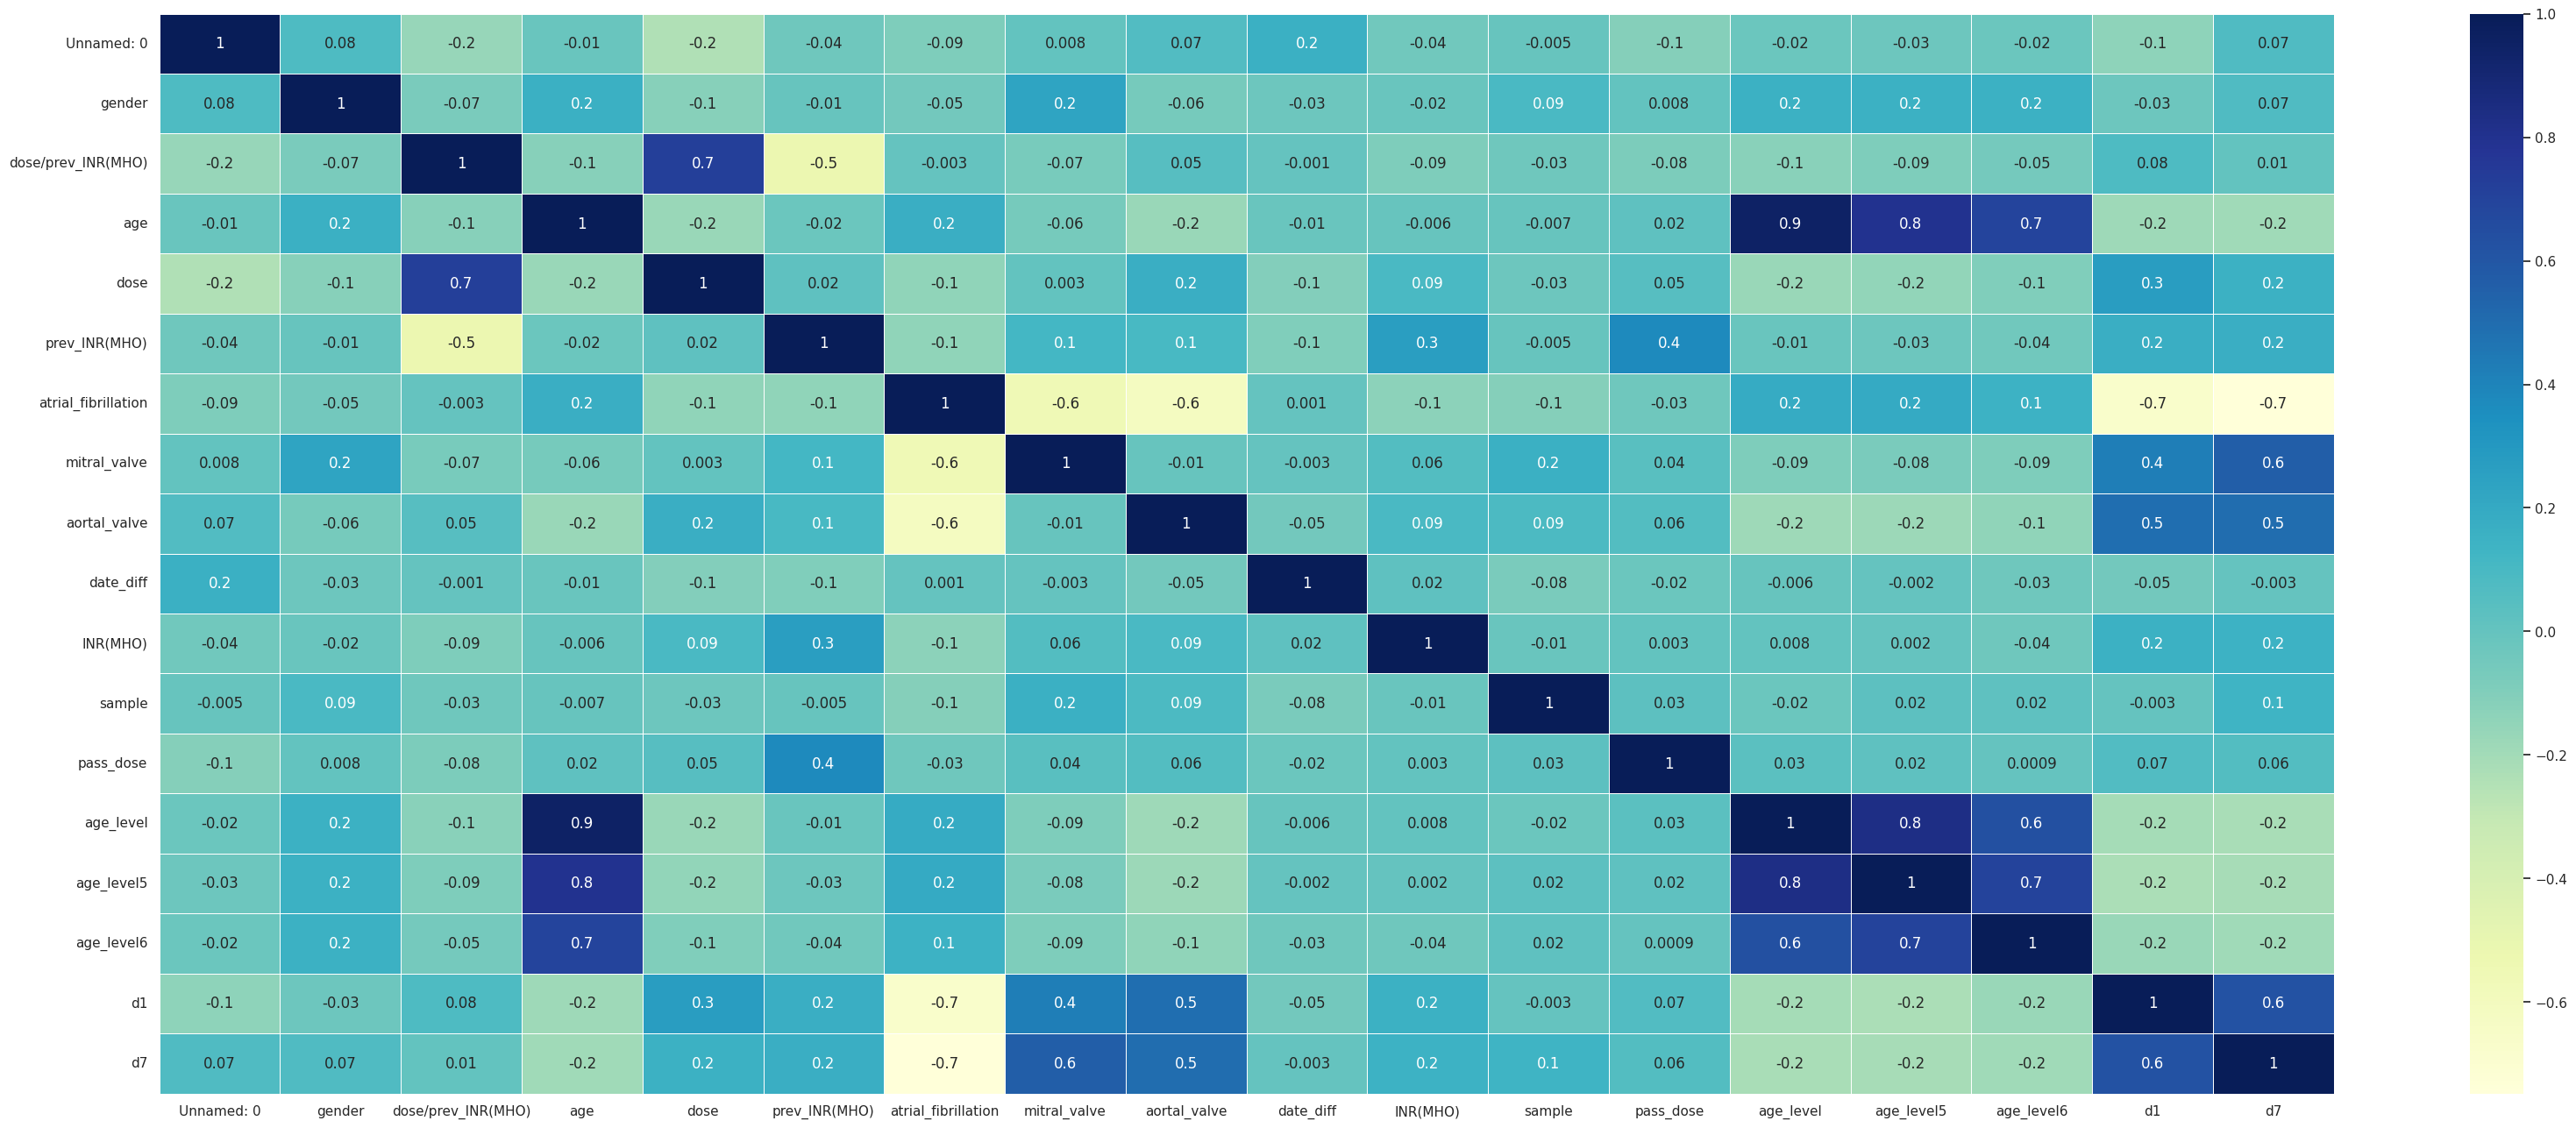

In [ ]:
# тепловая карта
sns.set(rc = {'figure.figsize':(40,16)})
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), linewidths=.5, annot=True, cmap='YlGnBu', fmt='.1g')

In [ ]:
# визуализация - тепловая карта phi_k
sns.set(rc = {'figure.figsize':(40,16)})
matrix = np.triu(data.phik_matrix())
sns.heatmap(data.phik_matrix(), linewidths=.5, annot=True, cmap='YlGnBu', fmt='.1g')

interval columns not set, guessing: ['Unnamed: 0', 'gender', 'dose/prev_INR(MHO)', '(analise-birth)_date', 'age', 'dose', 'prev_INR(MHO)', 'atrial_fibrillation', 'mitral_valve', 'aortal_valve', 'date_diff', 'INR(MHO)', 'sample', 'pass_dose', 'age_level', 'age_level5', 'age_level6', 'd1', 'd7']


TypeError: ignored

In [ ]:
# сохраним результаты
data.to_excel(catalogs_path+'ЦАТ_общий_parsed_plus_minus.xlsx')